In [1]:
import pandas as pd
import math
import os
import pickle
from dataclasses import dataclass

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import Dataset
import torch
#from transformers import AdamW, BertForSequenceClassification, BertTokenizer, DataCollatorWithPadding

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from transformers import AutoModel, AutoTokenizer

## Load Data

In [5]:
df_news = pd.read_csv('data/base_news_norm - base_labelv0.csv')

In [6]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   298 non-null    object
 1   label   298 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


In [7]:
df_news['label'].value_counts()

7    83
3    70
4    44
2    44
5    23
1    18
8    12
6     4
Name: label, dtype: int64

In [8]:
df_news = df_news[df_news['label'].isin([1,2,3,4,5])]

In [9]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 2 to 297
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   199 non-null    object
 1   label   199 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ KB


# Data Pipeline

#### Load BERT

In [10]:
%%time
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 1.45 s, sys: 332 ms, total: 1.78 s
Wall time: 10.6 s


In [11]:
def text_to_tensor(sent):
    """
    """
    input_ids = tokenizer.encode(sent, return_tensors='pt')
    
    with torch.no_grad():
        outs = model(input_ids)
        encoded = outs[0][0, 1:-1] 
        return encoded

In [12]:
k = 1
l = nn.AdaptiveAvgPool1d(k)
def adaptive_avg_pool1d(l, tensor):
    """
    """
    test = torch.transpose(tensor, 0, 1)
    res  = test.unsqueeze(0)
    output = l(res)
    output = output.squeeze(0)
    output = torch.transpose(output, 0, 1)
    
    return output

In [13]:
%%time
X_ada = []
for headline in df_news['title'].values:
    X_ada.append(np.array(adaptive_avg_pool1d(l,text_to_tensor(headline))[0]))
X_ada = np.array(X_ada)

CPU times: user 41 s, sys: 119 ms, total: 41.1 s
Wall time: 10.4 s


### Prepare dataframe train

In [14]:
df_model = pd.DataFrame(X_ada)

In [15]:
df_model['label'] = df_news['label'].values

# Model

In [16]:
from torch.autograd import Variable

In [17]:
def init_model():
    model = torch.nn.Sequential(
    torch.nn.Linear(768,768, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(768,768, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(768,5, bias=True),
    torch.nn.ReLU(),
    torch.nn.Softmax(dim=1))
    
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    
    return model, loss_function, optimizer

In [18]:
 model, loss_function, optimizer = init_model()

In [19]:
print(model)

Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): ReLU()
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): ReLU()
  (4): Linear(in_features=768, out_features=5, bias=True)
  (5): ReLU()
  (6): Softmax(dim=1)
)


## Sample train/test

In [20]:
def create_train_test(df, test_size):
    n = int((len(df) * test_size)/100)
    temp_test = df.sample(n)
    temp_train = df.drop(temp_test.index)
    return  temp_train, temp_test

In [21]:
# Label col must be the last one
def prepare_to_model_input(df):

    x_train = torch.from_numpy(np.array(df.values[:,:-1], dtype=np.float32))
    y = pd.get_dummies(df[df.columns[-1]])
    y_train = torch.from_numpy(y.to_numpy(dtype=np.float32))
    return x_train, y_train

In [22]:
def normalize_train_test(df, test_size):
    
    x_train, x_test, y_train, y_test = train_test_split(df.values[:,:-1], df[df.columns[-1]],random_state = 4, test_size = test_size, stratify = df[df.columns[-1]])
    
    train_label = y_train
    x_train = torch.from_numpy(np.array(x_train, dtype=np.float32))
    y_train = pd.get_dummies(y_train)
    y_train = torch.from_numpy(y_train.to_numpy(dtype=np.float32))
    
    test_label = y_test
    x_test = torch.from_numpy(np.array(x_test, dtype=np.float32))
    y_test = pd.get_dummies(y_test)
    y_test = torch.from_numpy(y_test.to_numpy(dtype=np.float32))
    
    return x_train, y_train, x_test, y_test, train_label, test_label

## Train

In [39]:
n_trains = 10
num_epoch = 4000
test_size = 30 # in %

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [66]:
#model(input)

In [41]:
resume_result = []
for n_train in range(n_trains):
    
    model, loss_function, optimizer = init_model()
    resut_dict = {}
    
    # Old version
    #df_train, df_test = create_train_test(df_model, test_size)
    #x_train, y_train = prepare_to_model_input(df_train)
    #x_test, y_test = prepare_to_model_input(df_test)
    
    # Sklearn version
    x_train, y_train, x_test, y_test, train_label, test_label = normalize_train_test(df_model, test_size/100)
    
    lost_res = []
    lost_test = []
    f1_test = []
    
    acc_train = []
    acc_test = []
    f1_train = []

    print("-------train {}-------".format(n_train))
    for epoch in range(num_epoch):
        input = Variable(x_train)
        target = Variable(y_train)
        
        input_test = Variable(x_test)
        target_test = Variable(y_test)  

        # forward Train
        out = model(input)
        loss = loss_function(out, target)

        # forward Test
        out_test = model(input_test)
        loss_test = loss_function(out_test, target_test)
        
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        lost_res.append(float(loss.data))
        lost_test.append(float(loss_test.data))
        
        # acc
        prediction = [] 
        for item in out:
            prediction.append(int(item.argmax())+1)
        #acc_train.append(accuracy_score(df_train['label'], prediction))
        acc_train.append(accuracy_score(train_label, prediction))
        f1_train.append(f1_score(train_label, prediction, average='weighted'))

        # acc
        prediction = [] 
        for item in out_test:
            prediction.append(int(item.argmax())+1)
        #acc_test.append(accuracy_score(df_test['label'], prediction))
        acc_test.append(accuracy_score(test_label, prediction))
        f1_test.append(f1_score(test_label, prediction, average='weighted'))

        # show
        if epoch % 400 == 0:
            print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'.format(epoch + 1, num_epoch, loss.data.item(), acc_train[epoch]))
            
    resume_result.append({'id':n_train, 'loss_train':lost_res, 'loss_test':lost_test, 'acc_train':acc_train, 'acc_test':acc_test, 'f1_train':f1_train,'f1_test':f1_test})
    print("---------------------------".format(n_train))

-------train 0-------
Epoch[1/4000], loss: 0.159857, acc: 0.223022


/home/gaivota/gaivota/work/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Epoch[401/4000], loss: 0.148068, acc: 0.352518
Epoch[801/4000], loss: 0.136043, acc: 0.417266
Epoch[1201/4000], loss: 0.121347, acc: 0.510791
Epoch[1601/4000], loss: 0.101139, acc: 0.589928
Epoch[2001/4000], loss: 0.085717, acc: 0.633094
Epoch[2401/4000], loss: 0.076025, acc: 0.654676
Epoch[2801/4000], loss: 0.069566, acc: 0.661871
Epoch[3201/4000], loss: 0.064931, acc: 0.661871
Epoch[3601/4000], loss: 0.061133, acc: 0.661871
---------------------------
-------train 1-------
Epoch[1/4000], loss: 0.159491, acc: 0.345324


/home/gaivota/gaivota/work/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Epoch[401/4000], loss: 0.144281, acc: 0.352518
Epoch[801/4000], loss: 0.130880, acc: 0.503597
Epoch[1201/4000], loss: 0.113060, acc: 0.618705
Epoch[1601/4000], loss: 0.085854, acc: 0.726619
Epoch[2001/4000], loss: 0.062383, acc: 0.776978
Epoch[2401/4000], loss: 0.049470, acc: 0.791367
Epoch[2801/4000], loss: 0.042595, acc: 0.812950
Epoch[3201/4000], loss: 0.038785, acc: 0.834532
Epoch[3601/4000], loss: 0.036728, acc: 0.848921
---------------------------
-------train 2-------
Epoch[1/4000], loss: 0.160178, acc: 0.115108


/home/gaivota/gaivota/work/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Epoch[401/4000], loss: 0.146843, acc: 0.352518
Epoch[801/4000], loss: 0.133661, acc: 0.453237
Epoch[1201/4000], loss: 0.118638, acc: 0.510791
Epoch[1601/4000], loss: 0.100313, acc: 0.582734
Epoch[2001/4000], loss: 0.085808, acc: 0.676259
Epoch[2401/4000], loss: 0.074714, acc: 0.676259
Epoch[2801/4000], loss: 0.065757, acc: 0.690647
Epoch[3201/4000], loss: 0.059198, acc: 0.697842
Epoch[3601/4000], loss: 0.055193, acc: 0.719424
---------------------------
-------train 3-------
Epoch[1/4000], loss: 0.160074, acc: 0.129496


/home/gaivota/gaivota/work/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Epoch[401/4000], loss: 0.158746, acc: 0.266187
Epoch[801/4000], loss: 0.156895, acc: 0.388489
Epoch[1201/4000], loss: 0.153206, acc: 0.410072
Epoch[1601/4000], loss: 0.145451, acc: 0.424460
Epoch[2001/4000], loss: 0.131173, acc: 0.424460
Epoch[2401/4000], loss: 0.115930, acc: 0.446043
Epoch[2801/4000], loss: 0.103389, acc: 0.489209
Epoch[3201/4000], loss: 0.094536, acc: 0.517986
Epoch[3601/4000], loss: 0.088462, acc: 0.532374
---------------------------
-------train 4-------
Epoch[1/4000], loss: 0.160060, acc: 0.172662


/home/gaivota/gaivota/work/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Epoch[401/4000], loss: 0.144775, acc: 0.352518
Epoch[801/4000], loss: 0.130449, acc: 0.467626
Epoch[1201/4000], loss: 0.111769, acc: 0.633094
Epoch[1601/4000], loss: 0.083865, acc: 0.733813
Epoch[2001/4000], loss: 0.061595, acc: 0.776978
Epoch[2401/4000], loss: 0.049438, acc: 0.798561
Epoch[2801/4000], loss: 0.042733, acc: 0.827338
Epoch[3201/4000], loss: 0.038936, acc: 0.834532
Epoch[3601/4000], loss: 0.036899, acc: 0.841727
---------------------------
-------train 5-------
Epoch[1/4000], loss: 0.159447, acc: 0.352518


/home/gaivota/gaivota/work/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Epoch[401/4000], loss: 0.147308, acc: 0.352518
Epoch[801/4000], loss: 0.135514, acc: 0.424460
Epoch[1201/4000], loss: 0.121468, acc: 0.510791
Epoch[1601/4000], loss: 0.102725, acc: 0.582734
Epoch[2001/4000], loss: 0.087265, acc: 0.625899
Epoch[2401/4000], loss: 0.076372, acc: 0.669065
Epoch[2801/4000], loss: 0.068588, acc: 0.719424
Epoch[3201/4000], loss: 0.062021, acc: 0.748201
Epoch[3601/4000], loss: 0.055171, acc: 0.769784
---------------------------
-------train 6-------
Epoch[1/4000], loss: 0.159856, acc: 0.223022


/home/gaivota/gaivota/work/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Epoch[401/4000], loss: 0.144629, acc: 0.352518
Epoch[801/4000], loss: 0.130344, acc: 0.496403
Epoch[1201/4000], loss: 0.111572, acc: 0.625899
Epoch[1601/4000], loss: 0.083411, acc: 0.748201
Epoch[2001/4000], loss: 0.058285, acc: 0.805755
Epoch[2401/4000], loss: 0.044122, acc: 0.856115
Epoch[2801/4000], loss: 0.035763, acc: 0.870504
Epoch[3201/4000], loss: 0.029792, acc: 0.884892
Epoch[3601/4000], loss: 0.026180, acc: 0.884892
---------------------------
-------train 7-------
Epoch[1/4000], loss: 0.160280, acc: 0.165468


/home/gaivota/gaivota/work/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Epoch[401/4000], loss: 0.159030, acc: 0.223022
Epoch[801/4000], loss: 0.157138, acc: 0.258993
Epoch[1201/4000], loss: 0.154030, acc: 0.302158
Epoch[1601/4000], loss: 0.148588, acc: 0.374101
Epoch[2001/4000], loss: 0.137413, acc: 0.446043
Epoch[2401/4000], loss: 0.121812, acc: 0.474820
Epoch[2801/4000], loss: 0.108444, acc: 0.474820
Epoch[3201/4000], loss: 0.098787, acc: 0.489209
Epoch[3601/4000], loss: 0.092848, acc: 0.496403
---------------------------
-------train 8-------
Epoch[1/4000], loss: 0.159863, acc: 0.223022


/home/gaivota/gaivota/work/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Epoch[401/4000], loss: 0.144895, acc: 0.352518
Epoch[801/4000], loss: 0.130461, acc: 0.510791
Epoch[1201/4000], loss: 0.111187, acc: 0.647482
Epoch[1601/4000], loss: 0.082474, acc: 0.726619
Epoch[2001/4000], loss: 0.058369, acc: 0.805755
Epoch[2401/4000], loss: 0.044893, acc: 0.841727
Epoch[2801/4000], loss: 0.036816, acc: 0.863309
Epoch[3201/4000], loss: 0.031280, acc: 0.877698
Epoch[3601/4000], loss: 0.026933, acc: 0.884892
---------------------------
-------train 9-------
Epoch[1/4000], loss: 0.159970, acc: 0.223022


/home/gaivota/gaivota/work/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Epoch[401/4000], loss: 0.151917, acc: 0.352518
Epoch[801/4000], loss: 0.137562, acc: 0.474820
Epoch[1201/4000], loss: 0.121117, acc: 0.575540
Epoch[1601/4000], loss: 0.092021, acc: 0.697842
Epoch[2001/4000], loss: 0.064448, acc: 0.769784
Epoch[2401/4000], loss: 0.048037, acc: 0.834532
Epoch[2801/4000], loss: 0.038878, acc: 0.863309
Epoch[3201/4000], loss: 0.033778, acc: 0.870504
Epoch[3601/4000], loss: 0.030373, acc: 0.877698
---------------------------


## Result

In [52]:
resume_result.reverse()

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

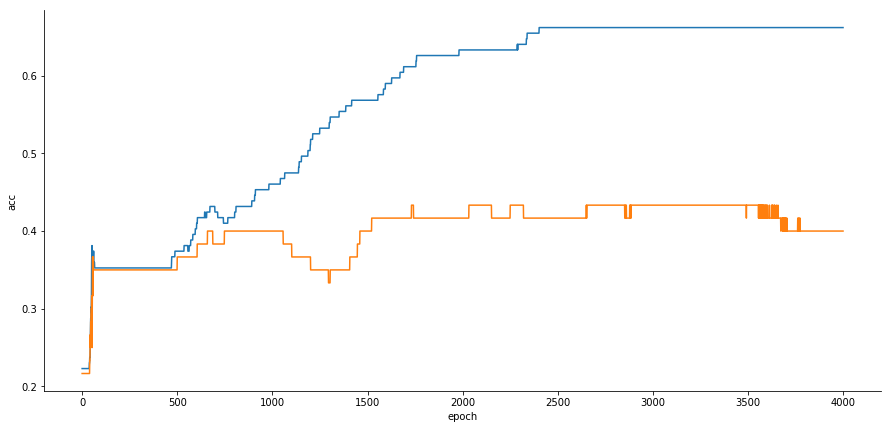

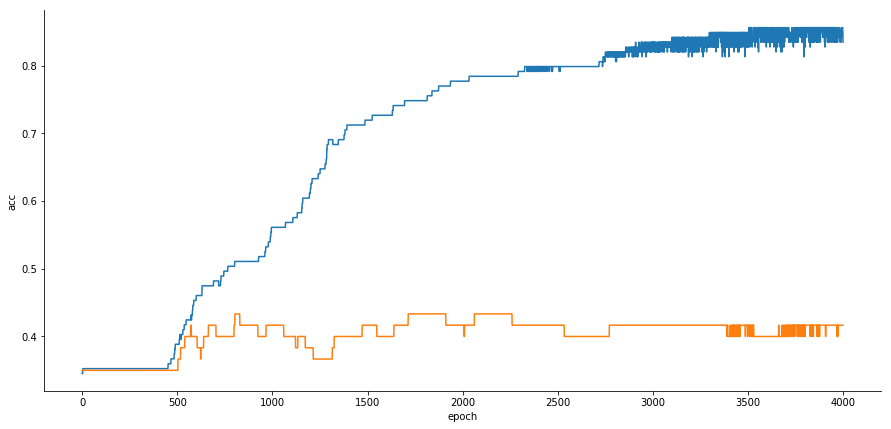

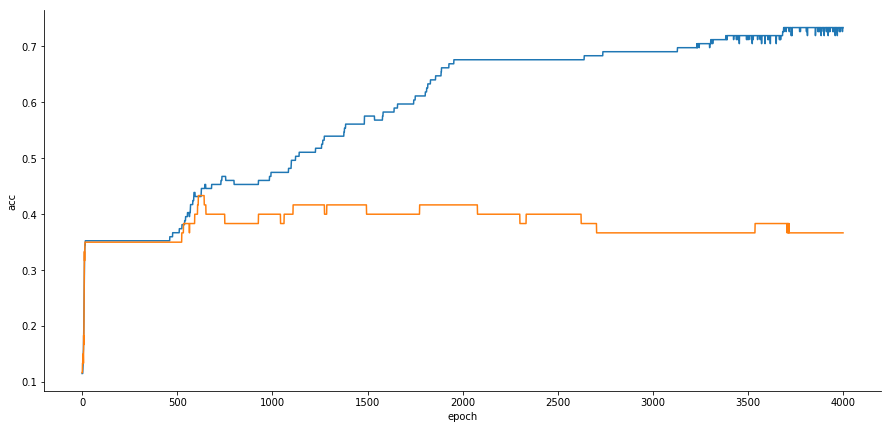

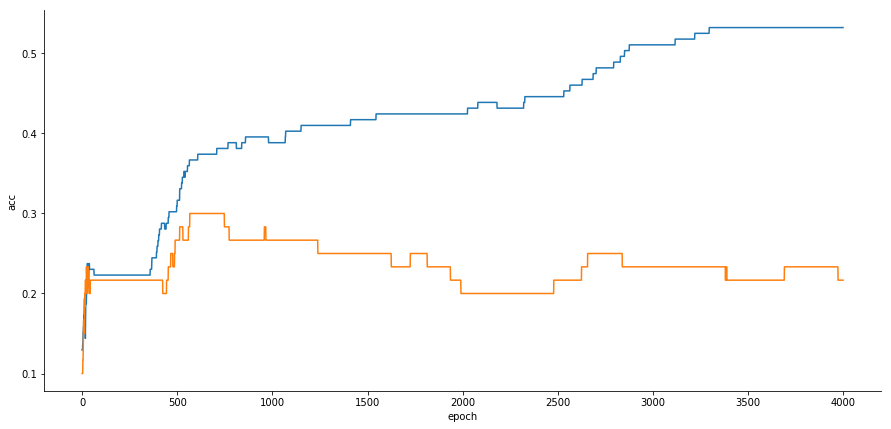

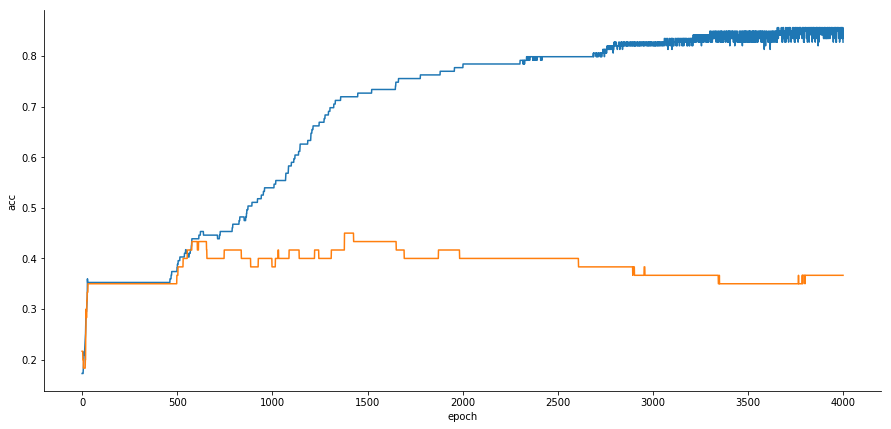

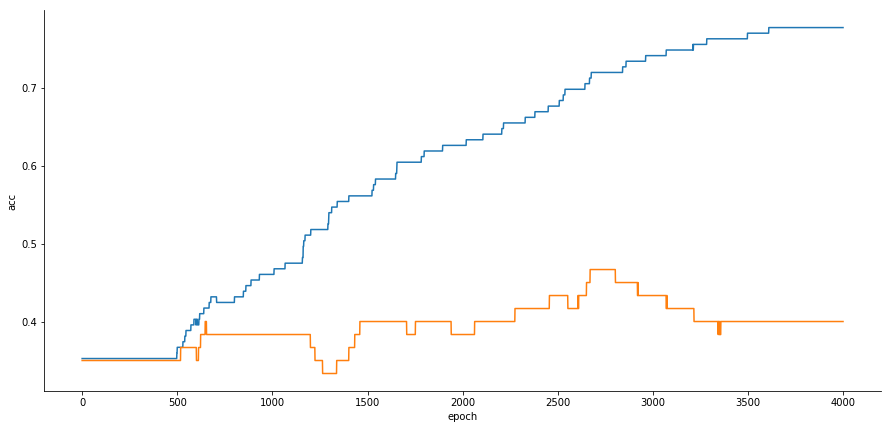

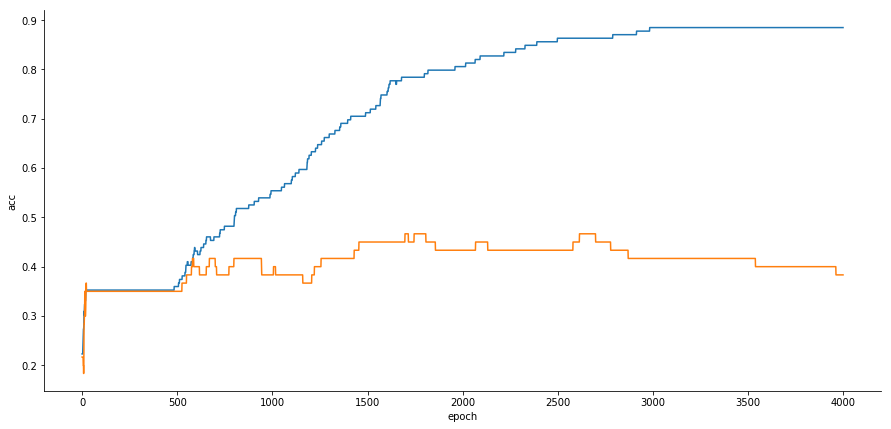

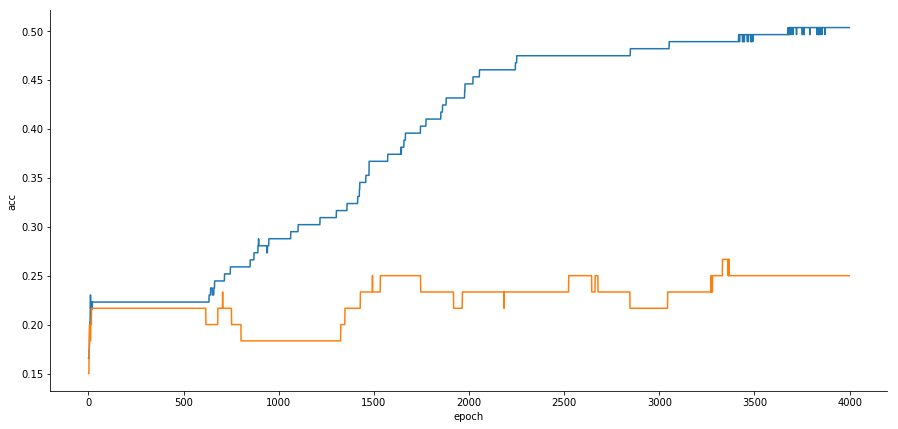

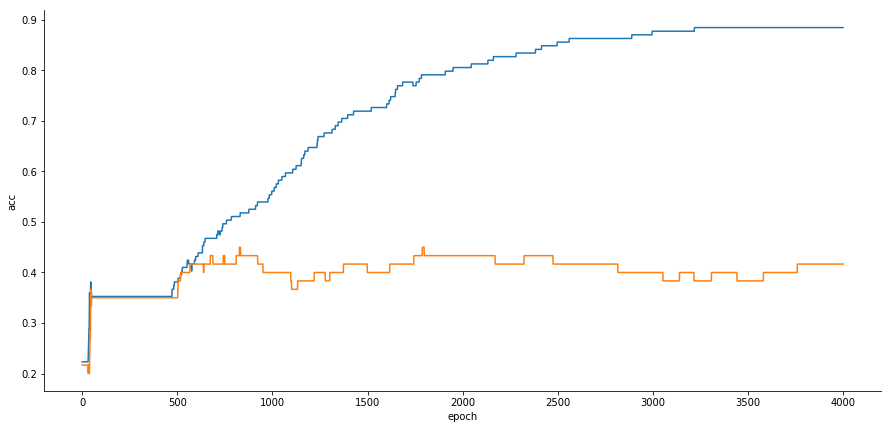

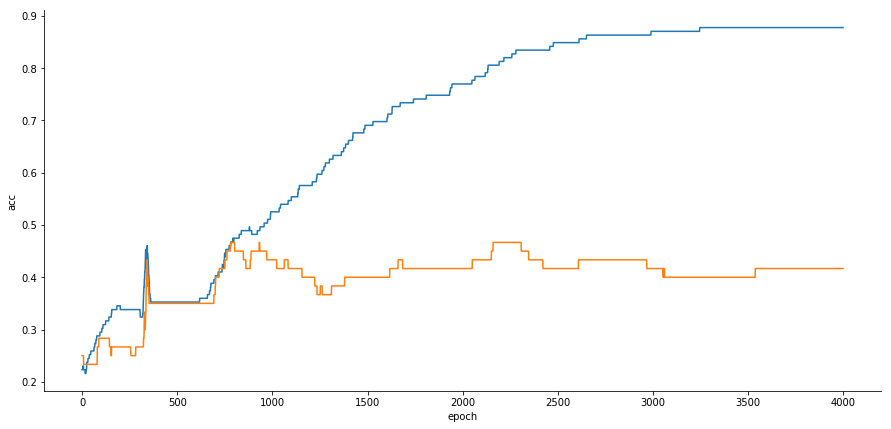

In [54]:
for x in range(n_trains):
    plt.figure(figsize=(15,7))
    sns.lineplot(data = resume_result[x]["acc_train"])
    sns.lineplot(data = resume_result[x]["acc_test"])
    plt.ylabel('acc')
    plt.xlabel('epoch')
    sns.despine()

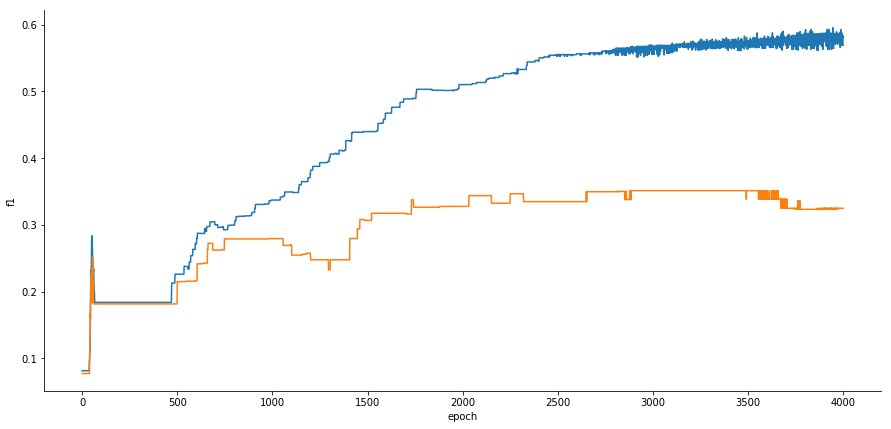

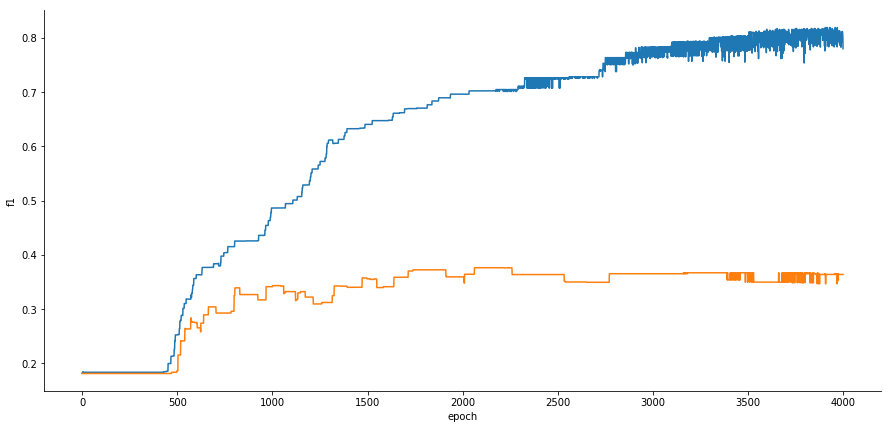

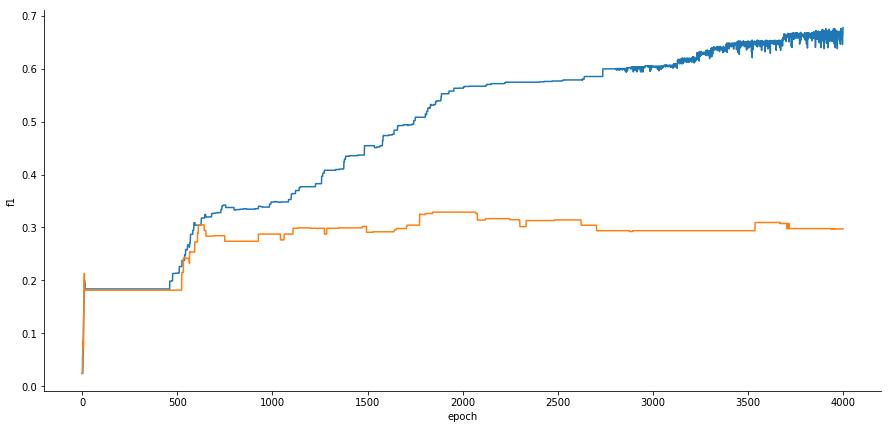

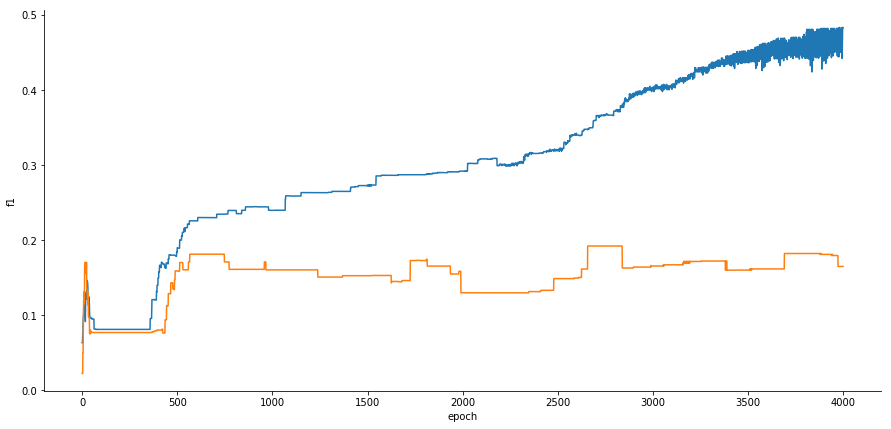

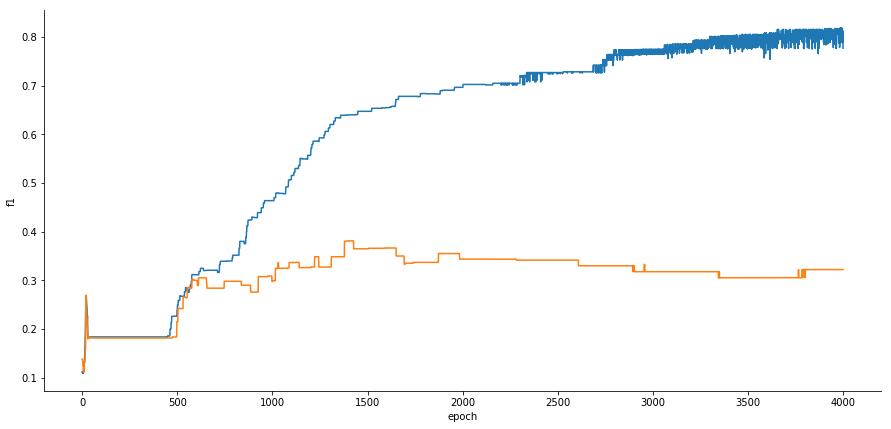

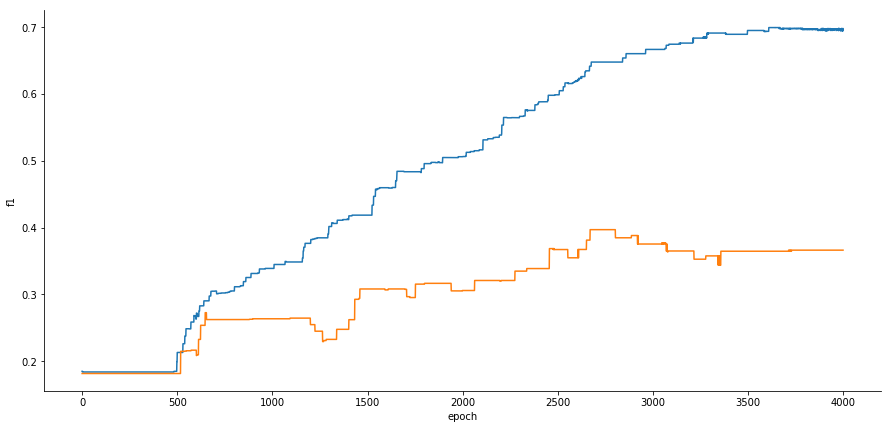

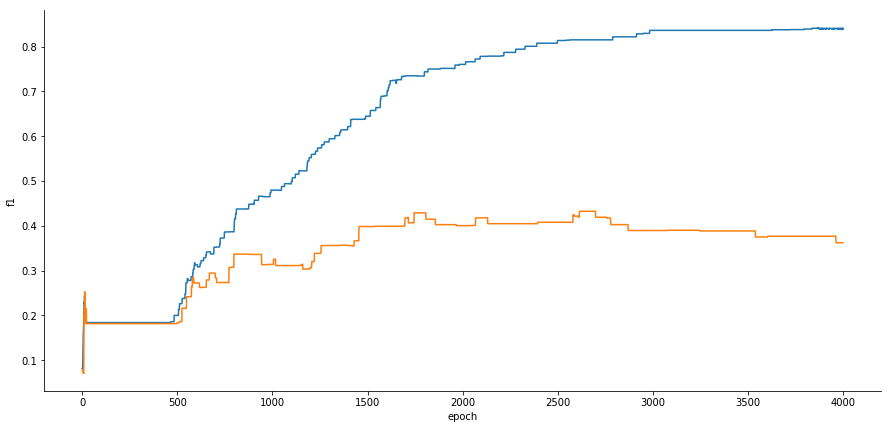

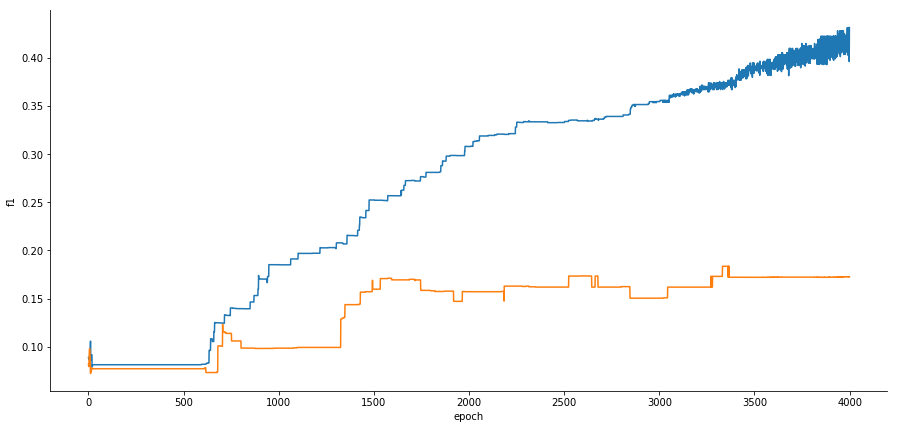

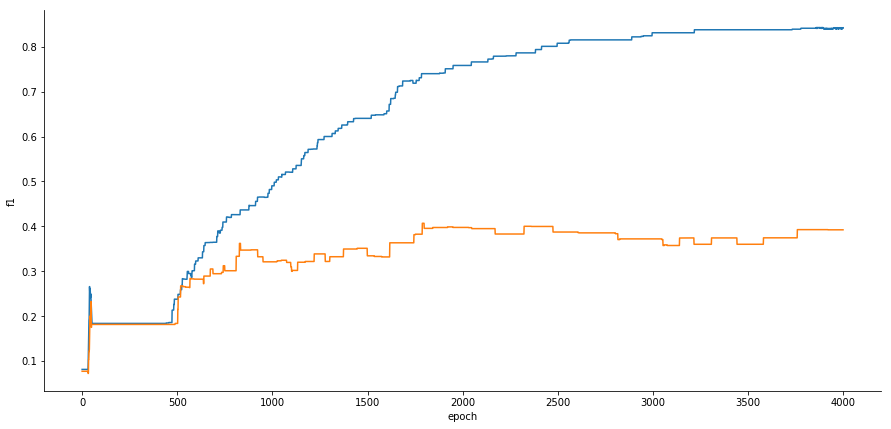

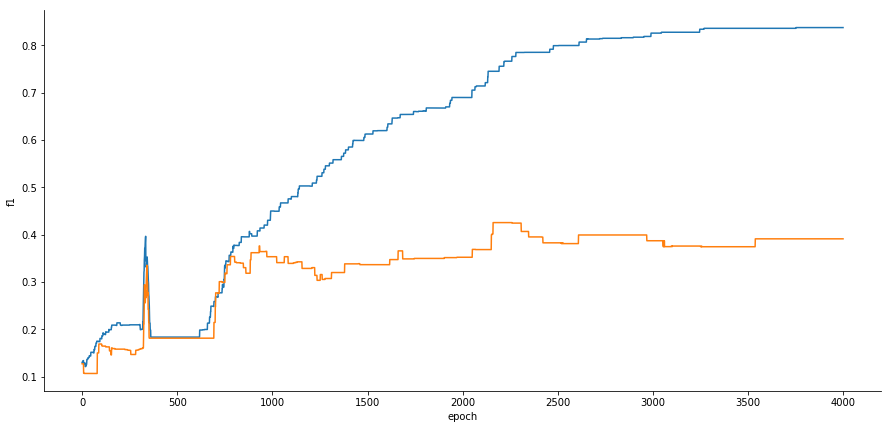

In [55]:
for x in range(n_trains):
    plt.figure(figsize=(15,7))
    sns.lineplot(data = resume_result[x]["f1_train"])
    sns.lineplot(data = resume_result[x]["f1_test"])
    plt.ylabel('f1')
    plt.xlabel('epoch')
    sns.despine()

In [56]:
acc_train_mean = np.zeros(num_epoch)
acc_test_mean = np.zeros(num_epoch)
for x in range(n_trains):
    acc_train_mean += resume_result[x]["acc_train"]
    acc_test_mean += resume_result[x]["acc_test"]
acc_train_mean = acc_train_mean/n_trains
acc_test_mean  = acc_test_mean/n_trains

In [57]:
acc_train_mean[-1]

0.7517985611510791

In [58]:
acc_test_mean[-1]

0.3633333333333333

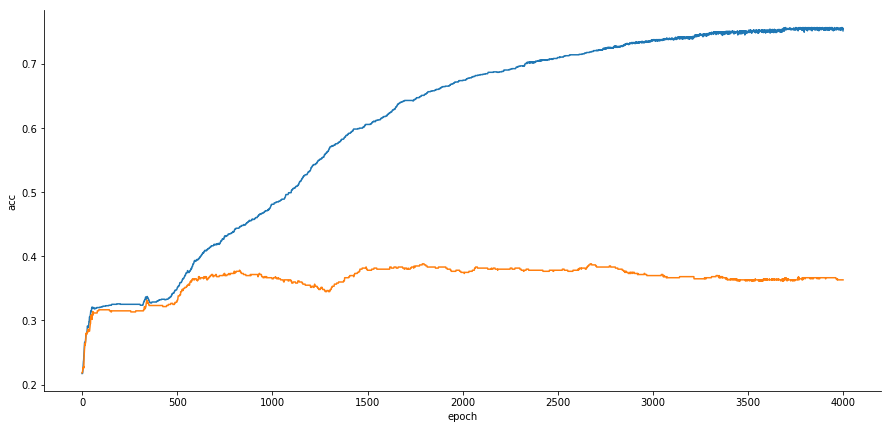

In [59]:
plt.figure(figsize=(15,7))
sns.lineplot(data = acc_train_mean)
sns.lineplot(data = acc_test_mean)
plt.ylabel('acc')
plt.xlabel('epoch')
sns.despine()

In [60]:
f1_train_mean = np.zeros(num_epoch)
f1_test_mean = np.zeros(num_epoch)
for x in range(n_trains):
    acc_train_mean += resume_result[x]["f1_train"]
    acc_test_mean += resume_result[x]["f1_test"]
f1_train_mean = acc_train_mean/n_trains
f1_test_mean  = acc_test_mean/n_trains

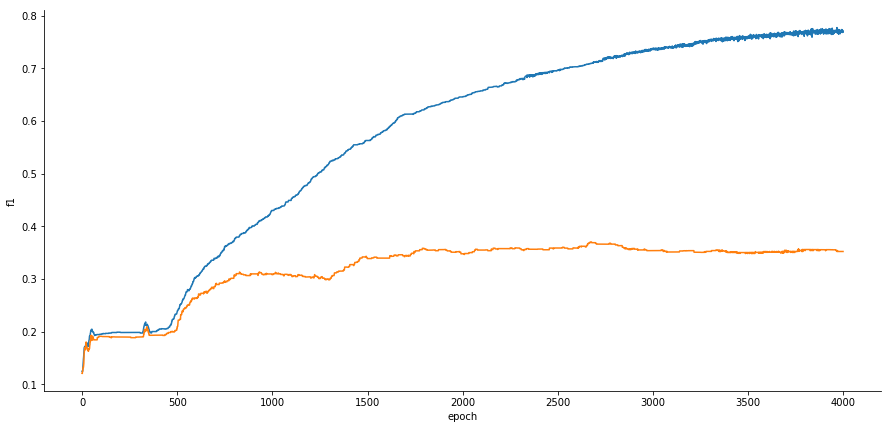

In [61]:
plt.figure(figsize=(15,7))
sns.lineplot(data = f1_train_mean)
sns.lineplot(data = f1_test_mean)
plt.ylabel('f1')
plt.xlabel('epoch')
sns.despine()

In [62]:
f1_train_mean[-1]

0.7687200165290976

In [63]:
f1_test_mean[-1]

0.35213117928753856